# TACHE 7 : el_bands_correction

**Corrections apportées :** Ce notebook est une version améliorée du notebook "el_bands".<br>
Rien n'a été corrigé mais des commentaires explicatifs ont été ajoutés dans les cellules de texte ainsi que dans le code afin de faciliter la compréhension.<br>

Dans ce notebook, nous allons déterminer la bande interdite du cristal SrCN₂, trouver la direction dans laquelle la dernière (première) bande de valence (conduction) présente le plus et le moins de dispersion, et, calculer la masse effective au sommet (base) de la dernière (première) bande de valence (conduction) en supposant une dispersion parabolique.

In [1]:
import numpy as np
from mp_api.client import MPRester
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.electronic_structure import bandstructure
from pymatgen.electronic_structure import plotter
from jupyter_jsmol.pymatgen import quick_view
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from IPython.display import Image
from tabulate import tabulate

In [2]:
mp_key = "hGFJONMWFhZMzX55ulNNTvmOkGE07nJS"
mp_id = "mp-12317"

In [3]:
with MPRester(mp_key) as m:
    prim_struc = m.get_structure_by_material_id(mp_id)
    el_bs = m.get_bandstructure_by_material_id(mp_id)
    el_dos = m.get_dos_by_material_id(mp_id)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

## Zone de Brillouin

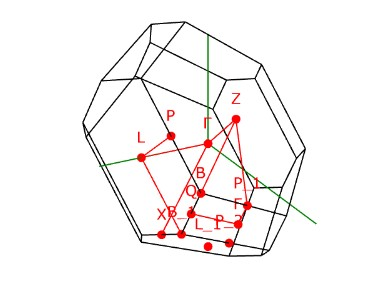

In [4]:
#plot_brillouin_zone(el_bs.structure)
display(Image(filename="el_brillouin.jpg"))

La première zone de Brillouin est la maille primitive de Weigner-Seitz du réseau réciproque, c'est-à-dire l'ensemble des points se trouvant plus près de l'origine $\Gamma$ que n'importe quel point du réseau réciproque.<br>

La première zone de Brillouin représente également l'ensemble des points de l'espace des vecteurs d'onde k qui peuvent être atteints à partir de l'origine sans traverser aucun des plans de Bragg. Ces plans sont des frontières dans l’espace réciproque où il peut y avoir diffraction des ondes électroniques. L'intérieur de la première zone de Brillouin correspond donc aux vecteurs d'onde non diffractés.<br>

Dans la théorie des bandes (modèle de Bloch), chaque vecteur d’onde k dans la première zone de Brillouin correspond à un état électronique avec une certaine énergie. Les solutions de l’équation de Schrödinger dans un cristal donnent des bandes d’énergie en fonction de k, et on construit la structure de bande à l’intérieur de cette zone.<br>

Cette zone est donc cruciale puisqu'elle contient toutes les informations nécessaires sur les énergies possibles des électrons dans le cristal.

## Bande interdite

La bande interdite dans un cristal désigne une plage d'énergie dans laquelle il n'y a pas d'états électronique disponibles; cela signifie qu'aucun électron ne peut occuper des niveaux d'énergie dans cette plage.

In [5]:
gap = el_bs.get_band_gap()
e_band = gap.get('energy')
print('Informations de la bande interdite : ')
print('Energie de la bande interdite :', e_band, 'eV.')
print('La bande interdite est-elle direct ? :',gap.get('direct'))
print('La bande interdite se situe entre 0 eV et {} eV.'.format(e_band))
print("Vecteur de transition :", gap['transition'])

Informations de la bande interdite : 
Energie de la bande interdite : 3.2055999999999996 eV.
La bande interdite est-elle direct ? : False
La bande interdite se situe entre 0 eV et 3.2055999999999996 eV.
Vecteur de transition : Z-\Gamma


La bande interdite du SrCN₂ est dite indirecte. En effet, nous pouvons remarquer sur le graphe que le haut de la bande de valence ne correspond pas au bas de la bande de conduction. La transition entre la bande de valence et la bande de conduction ne se fait pas au même point de l'espace des vecteurs d'onde du cristal. Les électrons doivent passer par une interaction avec un phonon pour que cette transition soit possible.<br>

L'énergie de la bande interdite vaut 3.206 eV. Cette valeur élevée nous indique que ce cristal est un semi-conducteur à large bande interdite.<br>

Le vecteur de transition précise la direction dans l’espace réciproque permettant le passage entre la dernière bande de valence et la première bande de conduction. En effet, nous remarquons sur le graphe ci-dessous que le vecteur d'onde associé à la dernière bande de valence est $Z$, et, celui de la première bande de conduction est $\Gamma$. 

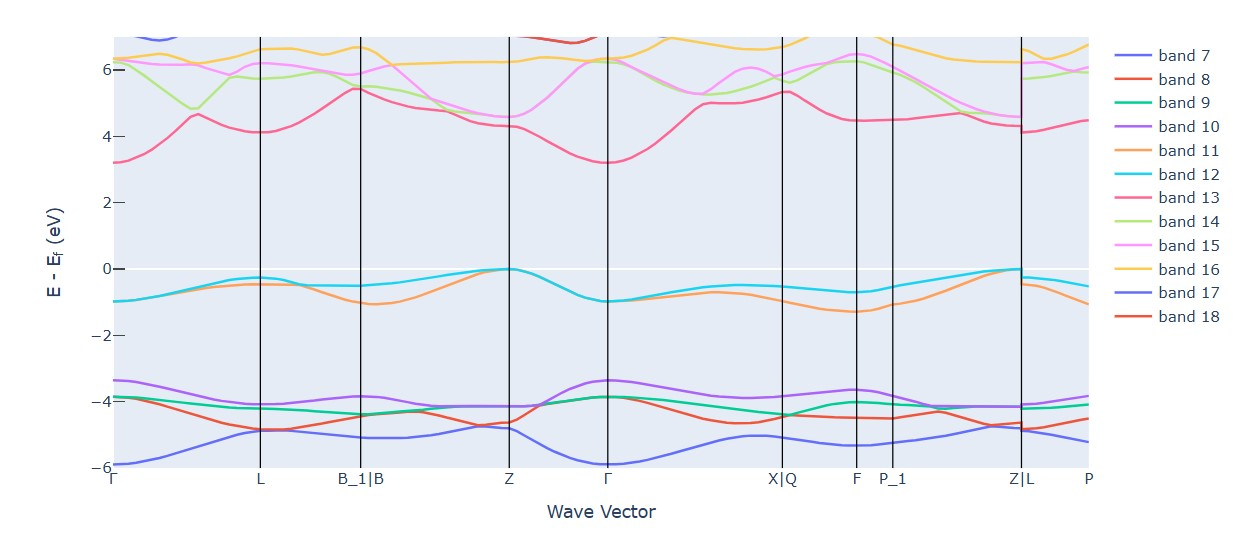

In [6]:
fig_el_bs = get_plot_bs(el_bs, plot_range=[-6,7])
#fig_el_bs.show()
display(Image(filename="el_b.jpg"))

## Dispersion

Dans cette section nous allons trouver la direction dans laquelle la dernière bande de valence présente le plus et le moins de dispersion ainsi que la direction dans laquelle la première bande de conduction présente le plus et le moins de dispersion.
Pour cela, nous allons calculer la pente de l'énergie en fonction du vecteur d'onde k pour chaque segment de la structure de bandes. En effet, une pente élevée signifie une forte variation d'énergie avec k indiquant une grande dispersion. A l'inverse, une pente faible indique une faible variation d'énergie avec k, indiquant une petite dispersion.<br>
Ensuite, nous déterminons la direction de ces grandes et petites dispersions grâce au graphique.

In [7]:
data = plotter.BSPlotter(el_bs).bs_plot_data()
# Analyse de la dernière bande de valence
vbm = el_bs.get_vbm()
E_vbm = vbm['energy']
kpoint_vbm = vbm['kpoint'].cart_coords
i_vbm = list(el_bs.get_vbm()['band_index'].values())[-1][-1]
print('Analyse de la dernière bande de valence')
print('   Energie du maximum de la bande de valence = {} eV'.format(E_vbm))
print('   Vecteur k  en coordonnées cartésiennes =', kpoint_vbm)
print('   Index de bande de valence =', i_vbm)

#Analyse de la première bande de conduction
cbm = el_bs.get_cbm()
E_cbm = cbm['energy']
kpoint_cbm = cbm['kpoint'].cart_coords
i_cbm = list(el_bs.get_cbm()['band_index'].values())[-1][0]
print('Analyse de la première bande de conduction')
print('   Energie du minimum de la première bande de conduction = ',E_cbm,'eV')
print('   Vecteur k en coordonnées cartésiennes =',kpoint_cbm)
print('   Index de bande de conduction =', i_cbm)

Analyse de la dernière bande de valence
   Energie du maximum de la bande de valence = 0.8311 eV
   Vecteur k  en coordonnées cartésiennes = [0.60515361 0.         0.13832782]
   Index de bande de valence = 11
Analyse de la première bande de conduction
   Energie du minimum de la première bande de conduction =  4.0367 eV
   Vecteur k en coordonnées cartésiennes = [0. 0. 0.]
   Index de bande de conduction = 12


La dispersion maximale de la dernière bande de valence se situe entre les abscisses [2.496488194843472, 3.1172502123107213]
 et entre les ordonnées [0.0, -0.9744999999999999]
La dispersion minimal de la dernière bande de valence se situe entre les abscisses [4.217137757821406, 4.685158179257835]
 et entre les ordonnées [-0.5267, -0.6997]
La dispersion maximale de la première bande de conduction se situe entre les abscisses [0.928580344007059, 1.5604476155501747]
 et entre les ordonnées [4.116099999999999, 5.4306]
La dispersion minimal de la première bande de conduction se situe entre les abscisses [4.685158179257835, 4.912676908826386]
 et entre les ordonnées [4.471299999999999, 4.4895]


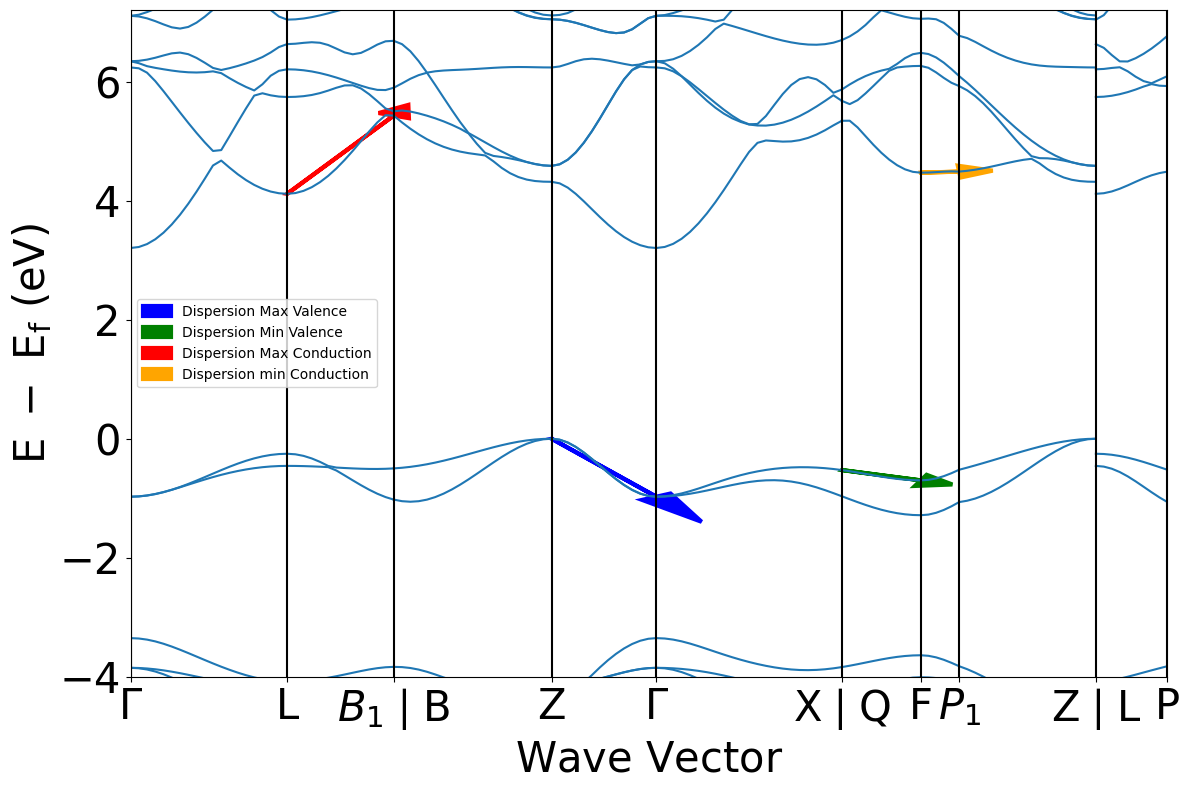

In [8]:
# Initialisation des variables pour suivre les pentes maximales et minimales
v_xi = 0
v_bandsi = 0
v_xf = 0
v_bandsf = 0

v_pente_max = 0
v_pente_min = 100

v_x_max = [0, 0]
v_bands_max = [0, 0]
v_x_min = [0, 0]
v_bands_min = [0, 0]

for i in range(len(data["distances"])): 
    v_x = data["distances"][i]    # Récupération de la distance k
    v_y = data["energy"]['1'][i]  # Récupération des énergies des bandes

    # Extraction des points de départ et de fin
    v_xi = v_x[0]   # Premier point k
    v_xf = v_x[-1]  # Dernier point k

    v_bandsi = v_y[i_vbm][0]  # Énergie initiale
    v_bandsf = v_y[i_vbm][-1]  # Énergie finale
    # Calcul de la pente
    v_pente = np.abs((v_bandsf - v_bandsi) / (v_xf - v_xi))  

    # Mise à jour des valeurs maximales et minimales
    if v_pente >= v_pente_max:
        v_pente_max = v_pente
        v_x_max = [v_xi, v_xf]
        v_bands_max = [v_bandsi, v_bandsf]

    if v_pente <= v_pente_min:
        v_pente_min = v_pente
        v_x_min = [v_xi, v_xf]
        v_bands_min = [v_bandsi, v_bandsf]

# Initialisation des variables pour suivre les pentes maximales et minimales
c_xi = 0
c_bandsi = 0
c_xf = 0
c_bandsf = 0

c_x_max = [0, 0]
c_bands_max = [0, 0]
c_x_min = [0, 0]
c_bands_min = [0, 0]

c_pente_max = 0
c_pente_min = 100

for i in range(len(data["distances"])): 
    c_x = data["distances"][i]  # Récupération de la distance k
    c_y = data["energy"]['1'][i]  # Récupération des énergies des bandes

    # Extraction des points de départ et de fin
    c_xi = c_x[0]  # Premier point k
    c_xf = c_x[-1]  # Dernier point k

    c_bandsi = c_y[i_cbm][0]  # Énergie initiale
    c_bandsf = c_y[i_cbm][-1]  # Énergie finale
    # Calcul de la pente
    c_pente = np.abs((c_bandsf - c_bandsi) / (c_xf - c_xi))  

    # Mise à jour des valeurs maximales et minimales
    if c_pente >= c_pente_max:
        c_pente_max = c_pente
        c_x_max = [c_xi, c_xf]
        c_bands_max = [c_bandsi, c_bandsf]

    if c_pente <= c_pente_min:
        c_pente_min = c_pente
        c_x_min = [c_xi, c_xf]
        c_bands_min = [c_bandsi, c_bandsf]

print('La dispersion maximale de la dernière bande de valence se situe entre les abscisses ' + str(v_x_max) + 
      '\n et entre les ordonnées ' + str(v_bands_max))
print('La dispersion minimal de la dernière bande de valence se situe entre les abscisses ' + str(v_x_min) + 
      '\n et entre les ordonnées ' + str(v_bands_min))
print('La dispersion maximale de la première bande de conduction se situe entre les abscisses ' + str(c_x_max) + 
      '\n et entre les ordonnées ' + str(c_bands_max))
print('La dispersion minimal de la première bande de conduction se situe entre les abscisses ' + str(c_x_min) + 
      '\n et entre les ordonnées ' + str(c_bands_min))
# Obtention de la figure existante
BSPlotter(el_bs).get_plot()

# Flèches pour la bande de valence (bleu)
plt.arrow(v_x_max[0], v_bands_max[0], v_x_max[1] - v_x_max[0], v_bands_max[1] - v_bands_max[0],
         head_width=0.2, head_length=0.5,linewidth=3, fc='blue', ec='blue', label="Dispersion Max Valence")

plt.arrow(v_x_min[0], v_bands_min[0], v_x_min[1] - v_x_min[0], v_bands_min[1] - v_bands_min[0],
         head_width=0.2, head_length=0.2, linewidth=3, fc='green', ec='green', label="Dispersion Min Valence")

# Flèches pour la bande de conduction (rouge)
plt.arrow(c_x_max[0], c_bands_max[0], c_x_max[1] - c_x_max[0], c_bands_max[1] - c_bands_max[0],
         head_width=0.2, head_length=0.2, linewidth=3, fc='red', ec='red', label="Dispersion Max Conduction")

plt.arrow(c_x_min[0], c_bands_min[0], c_x_min[1] - c_x_min[0], c_bands_min[1] - c_bands_min[0],
         head_width=0.2, head_length=0.2,linewidth=3, fc='orange', ec='orange', label="Dispersion min Conduction")

plt.legend()
plt.show()

En analysans le graphique, nous remarquons: <br>
La plus faible dispersion de la dernière bande de valence est dans la direction X|Q-F et la direction de la plus grande dispersion est Z-$\Gamma$.<br>
La plus faible dispersion de la première bande de conduction est dans la direction F-P1 et la direction de la plus grande dispersion est L-B1|B.<br>

## Masse effective

Les électrons sont souvent décrits comme des particules libres dont la masse effective varie. Cette masse effective peut-être
positive ou négative, supérieure ou inférieure à la masse réelle de l'électron.<br>
La masse effective $m^*$ joue le rôle que jouait la masse $m$ pour un électron libre se déplaçant dans un milieu de potentiel constant. Cela signifie que le mouvement forcé d'un électron dans un solide est identique à celui d'une particule libre de masse $m^*$ soumise à la même force.<br>


De façon général, la masse effective est définie par le tenseur d'ordre deux des dérivées secondes de l'énergie E par rapport au vecteur d'onde k : $$m^*_{ij} = \left( \frac{\partial^2 E}{\partial k_i \partial k_j} \right)^{-1}$$
Cette formule nous permet de comprendre que la masse effective est définie par la courbure de la relation de dispersion.<br>


Nous étudions ici la masse effective au sommet de la dernière bande de valence et à la base de la première bande de conduction. Pour simplifier les calculs, nous supposons une dispersion parabolique, ce qui permet de modéliser la relation entre l’énergie et le vecteur d’onde par une parabole.<br>
La masse effective est donc définie par  $$m^* = \left( \frac{ℏ²}{2*a} \right)$$ avec l'équation d'une parabole $$ y = a k^2 + b k + c $$

In [9]:
#Conversion d'unité
hbar = ((6.62607004*10**(-34))/(2*np.pi))**2 #ℏ²
electronvolt = 1.602176634*10**(-19) #eV en J
angstrom = 10**(-10)  #Å en m


--------------------------  ---------------------------------------------------------------------
Parabole d'approximation :  y(k) = -5.0484225905104205k² + 25.02492704308407k -31.010376870554623
Dérivée seconde :           -10.096845181020841 eVÅ²
Masse effective :           -6.87473903329951e-31 kg


La masse effective obtenue est négative car nous nous trouvons à un maximum de bande.
Une masse effective négative exprime que la vitesse acquise sous l'action d'une force F
est de sens contraite à celle que prendrait dans le vide un électron soumis à F.




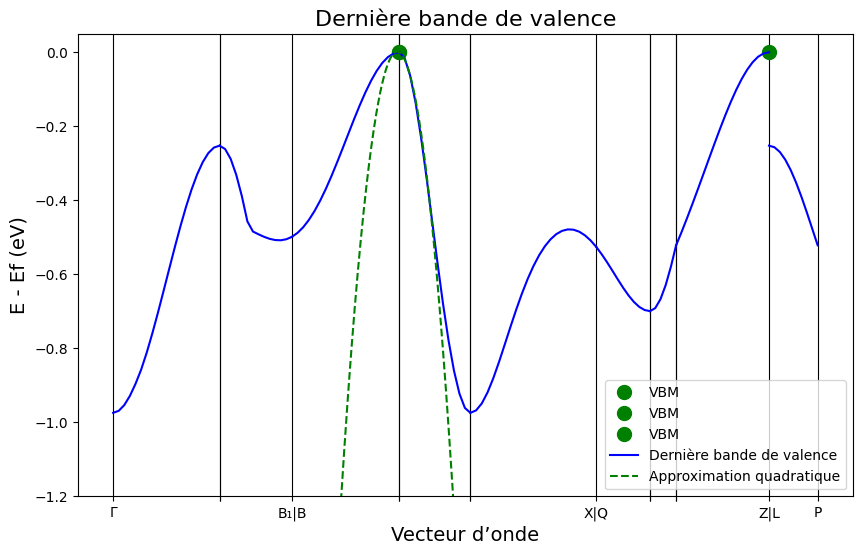

In [10]:
# Affichage d'un graphe avec uniquement la dernière bande de valence
vbms = data.get('vbm')
fig, ax = plt.subplots(figsize=(10, 6))
distance = data.get('ticks').get('distance')
for d in distance:
    ax.axvline(d, color="black", linewidth=0.8)

for a, b in vbms:
    ax.plot(a, b, 'og', markersize=10, label='VBM')

for i in range(len(data["distances"])):
    ax.plot(data["distances"][i], data["energy"]['1'][i][i_vbm], 'b', label="Dernière bande de valence" if i == 0 else "")

# Étiquettes et axes
ax.set_xticks(distance)
ax.set_xticklabels(['\u0393', 'L', '', 'B\u2081|B', 'Z', '', '\u0393', '', 'X|Q', 'F', '', 'P\u2081', '', 'Z|L', 'P'])
ax.set_xlabel('Vecteur d’onde', fontsize=14)
ax.set_ylabel('E - Ef (eV)', fontsize=14)
ax.set_title('Dernière bande de valence', fontsize=16)

ax.set_ylim(-1.2, None)

# Récupération de trois points (le VBM + un à gauche et un à droite) pour ajuster une parabole
ks = np.zeros(3)
es = np.zeros(3)
ks[1], es[1] = vbms[1]
ks[0], es[0] = data["distances"][2][-2], data["energy"]['1'][2][i_vbm][-2]
ks[2], es[2] = data["distances"][3][2],  data["energy"]['1'][3][i_vbm][2]

# Calcul de la masse effective
a = np.polyfit(ks, es, 2)
m_v = (hbar/(2*a[0]*electronvolt*(angstrom)**2))

# Affichage des résultats
print(tabulate([["Parabole d'approximation : ","y(k) = "+str(a[0])+"k\u00b2 + "+str(a[1])+"k "+str(a[2])],
               ["Dérivée seconde : ",str(2*a[0])+" eV\u212b\u00b2"],
                ["Masse effective : ",str(hbar/(2*a[0]*electronvolt*(angstrom)**2))+" kg"]],
                headers=["",""]))
print("\n")
print("La masse effective obtenue est négative car nous nous trouvons à un maximum de bande.")
print("Une masse effective négative exprime que la vitesse acquise sous l'action d'une force F") 
print("est de sens contraite à celle que prendrait dans le vide un électron soumis à F.")
print("\n")
# Ajustement de la parabole autour du VBM
x = np.linspace(data["distances"][2][0],data["distances"][3][-1],1000)
ax.plot(x, np.polyval(a, x), 'g--', label='Approximation quadratique')
plt.legend()
plt.show()


--------------------------  -------------------------------------------------------------------
Parabole d'approximation :  y(k) = 6.405012491867265k² + -39.875417645722806k 65.26815361972616
Dérivée seconde :           12.81002498373453 eVÅ²
Masse effective :           5.418660445025132e-31 kg


La masse effective obtenue est positive car nous nous trouvons à un minimum de bande.




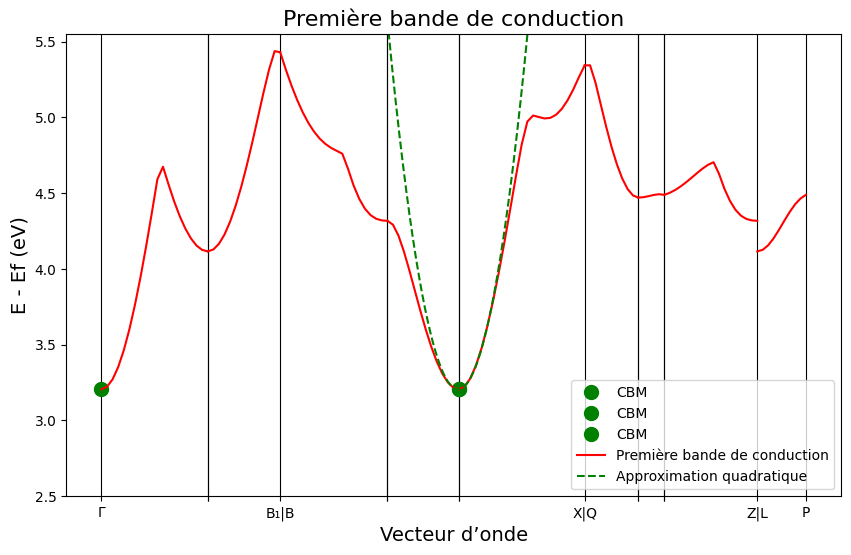

In [11]:
# Affichage d'un graphe avec uniquement la première bande de conduction
cbms = data.get('cbm')
fig, ax = plt.subplots(figsize=(10, 6))
distance = data.get('ticks').get('distance')
for d in distance:
    ax.axvline(d, color="black", linewidth=0.8)

for a, b in cbms:
    ax.plot(a, b, 'og', markersize=10, label='CBM')

for i in range(len(data["distances"])):
    ax.plot(data["distances"][i], data["energy"]['1'][i][i_cbm], 'r', label="Première bande de conduction" if i == 0 else "")
# Étiquettes et axes
ax.set_xticks(distance)
ax.set_xticklabels(['\u0393', 'L', '', 'B\u2081|B', 'Z', '', '\u0393', '', 'X|Q', 'F', '', 'P\u2081', '', 'Z|L', 'P'])
ax.set_xlabel('Vecteur d’onde', fontsize=14)
ax.set_ylabel('E - Ef (eV)', fontsize=14)
ax.set_title("Première bande de conduction", fontsize=16)

ax.set_ylim(2.5, None)

# Récupération de trois points (le CBM + un à gauche et un à droite) pour ajuster une parabole
ks2 = np.zeros(3)
es2 = np.zeros(3)
ks2[1], es2[1] = cbms[1]
ks2[0], es2[0] = data["distances"][3][-2], data["energy"]['1'][3][i_cbm][-2]
ks2[2], es2[2] = data["distances"][4][2],  data["energy"]['1'][4][i_cbm][2]

# Calcul de la masse effective
a2 = np.polyfit(ks2, es2, 2)
m_c=(hbar/(2*a2[0]*electronvolt*(angstrom)**2))

# Affichage des résultats
print(tabulate([["Parabole d'approximation : ","y(k) = "+str(a2[0])+"k\u00b2 + "+str(a2[1])+"k "+str(a2[2])],
               ["Dérivée seconde : ",str(2*a2[0])+" eV\u212b\u00b2"],
                ["Masse effective : ",str(hbar/(2*a2[0]*electronvolt*(angstrom)**2))+" kg"]],
                headers=["",""]))
print("\n")
print("La masse effective obtenue est positive car nous nous trouvons à un minimum de bande.")
print("\n")
# Ajustement de la parabole autour du CBM
x2 = np.linspace(data["distances"][3][0],data["distances"][4][-1],1000)
ax.plot(x2, np.polyval(a2, x2), 'g--', label='Approximation quadratique')
plt.legend()
plt.show()

In [12]:
m_e = 9.109e-31
print('Masse de l électron libre: m = {:.4e} kg.'.format(m_e))
print('Rapports de masse :')
print('Au sommet de la dernière bande de valence: m*/m = ',m_v/m_e)
print('A la base de la première bande de conduction : m*/m = ',m_c/m_e)

Masse de l électron libre: m = 9.1090e-31 kg.
Rapports de masse :
Au sommet de la dernière bande de valence: m*/m =  -0.7547194020528609
A la base de la première bande de conduction : m*/m =  0.5948688599215208


Nous remarquons que les deux rapports de masse effective sont inférieurs à 1, ce qui indique une forte dépendance de l’énergie au vecteur d’onde k et une plus grande mobilité des électrons (ou des trous) comparée à celle d’électrons libres.<br>
Ce comportement s’explique par le recouvrement des fonctions d’onde entre atomes voisins : lorsqu’il est faible, la bande d’énergie est étroite, ce qui conduit à une masse effective élevée.
À l’inverse, un recouvrement important permet une plus grande délocalisation des électrons, élargit la bande d’énergie, et se traduit par une masse effective plus faible.